# Compute metrics using HOI package

Import libraries

In [60]:
import numpy as np
import pandas as pd
from collections import defaultdict
import hoi
from hoi.plot import plot_landscape
from hoi.utils import get_nbest_mult
from numpy import random
import matplotlib.pyplot as plt
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID

Define functions

In [81]:
# Function to compute a desired information metric
def compute_information_metric(metric, data):
    data_array=np.array(np.array(data)).astype(float)
    model = metric(data_array)
    metric_results = model.fit(minsize=2,maxsize=5)
    return metric_results, model

# Function to divide list into list per order
def divide_list_into_orders(hoi, model):
    minsize = None
    maxsize = None

    # get orders
    if model:
        orders = model.order

    # get computed orders
    if minsize is None:
        minsize = orders.min()
    if maxsize is None:
        maxsize = orders.max()   

    # order selection
    keep = np.logical_and(orders >= minsize, orders <= maxsize)
    hoi = hoi[keep]
    orders = orders[keep]

    # Group the values per order
    grouped = defaultdict(list)
    for o, h in zip(orders, hoi):
        grouped[o].append(h.item())  # Convert from NumPy array to float

    # Sort each list
    for key in grouped:
        grouped[key] = sorted(grouped[key])

    return grouped

# Function to plot row of histograms for all orders
def histogram_per_order(grouped, metric):
    # Sort grouped values
    for key in grouped:
        grouped[key] = sorted(grouped[key])

    # Prepare keys
    unique_orders = sorted(grouped.keys())
    all_values = sum(grouped.values(), [])  # Flatten all lists

    # Include "All Orders"
    plot_keys = ['All'] + unique_orders
    datasets = [all_values] + [grouped[k] for k in unique_orders]
    num_plots = len(datasets)

    # Create subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4), sharey=True)

    if num_plots == 1:
        axes = [axes]

    # Plot each histogram normalized by its max count
    for ax, title, data in zip(axes, plot_keys, datasets):
        counts, bins = np.histogram(data, bins='auto')
        counts = counts / counts.max() if counts.max() != 0 else counts  # Normalize to max 1
        ax.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color='skyblue', edgecolor='black')
        ax.set_title(f'{title if title != "All" else "All Orders"}')
        ax.set_xlabel('Metric value')
        ax.set_ylim(0, 1.05)  # Make space for label visibility

    # Optional: Label y-axis on the first plot
    axes[0].set_ylabel('Normalized Frequency (max = 1)')

    plt.suptitle(f'{metric.__name__} analysis')
    plt.tight_layout()
    plt.savefig(f'Results\\Random_timeseries\\{metric.__name__}_analysis.png', dpi=300)
    plt.close()

# Analyse the choosen metric with a row of histograms
def analyse_information_metric(metric, data):
    # Compute information metric
    metric_values, model = compute_information_metric(metric, data)
    
    # Divide list into lists per order
    divided_dict = divide_list_into_orders(metric_values, model)

    # Plot row of histograms per order
    histogram_per_order(divided_dict, metric)

Create random timeseries to test

In [82]:
n_timesteps = 100
n_variables = 20  

data = np.random.randn(n_timesteps, n_variables)
columns = [f'X{i+1}' for i in range(n_variables)]
df = pd.DataFrame(data, columns=columns)

Analyse metric values (choose from InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID)

In [83]:
metrics = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]

for metric in metrics:
    analyse_information_metric(metric, df)

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/5 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/21679 [00:00<?, ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Plot metric landscape

<Axes: xlabel='Order', ylabel='Topological Information [Bits]'>

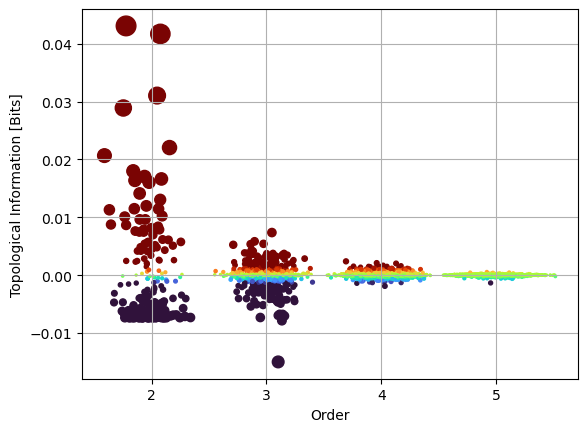

In [35]:
plot_landscape(
    metric_results,
    model,
    kind="scatter",
    undersampling=False,
    plt_kwargs=dict(cmap="turbo"),
)